<a href="https://colab.research.google.com/github/Huypham07/Student-performance-prediction/blob/huy-branch/Student_Performance_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Student Performance Prediction

**Vấn đề**: Hệ thống cảnh báo sớm học sinh có nguy cơ trượt môn, dự đoán điểm của học sinh ở kỳ kiểm tra tiếp theo dựa trên kết quả học tập hiện tại, thói quen học tập, yếu tố cá nhân.

**Môn học:** Data Science  
**Thành viên nhóm:** ...  
**Dataset:** Student Performance Prediction  

---

## Mục tiêu:
1. Phân tích mô tả dữ liệu, tìm hiểu các yếu tố ảnh hưởng đến điểm số học sinh.
2. Phát hiện học sinh có nguy cơ trượt môn (Điểm < 40)
3. Dự đoán điểm của học sinh ở kỳ kiểm tra tiếp theo

---
## Outline các phần chính:
1. EDA & Xác định yếu tố ảnh hưởng
2. Phân loại học sinh
3. Dự đoán điểm số
4. Hồi quy: Dự đoán điểm Toán
5. Đánh giá mô hình


## 1. EDA & Xác định yếu tố ảnh hưởng
- Chuẩn bị thư viện, dataset
- Phân tích thống kê
- Xác định feature quan trọng nhất ảnh hưởng tới điểm

### Import thư viện, dataset

In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from datascience import *

import scipy.stats as st

In [69]:
data = pd.read_csv('student_performance_dataset.csv')
data.head(5)

,Student_ID,Gender,Study_Hours_per_Week,Attendance_Rate,Past_Exam_Scores,Parental_Education_Level,Internet_Access_at_Home,Extracurricular_Activities,Final_Exam_Score,Pass_Fail
0,S147,Male,31,68.267841,86,High School,Yes,Yes,63,Pass
1,S136,Male,16,78.222927,73,PhD,No,No,50,Fail
2,S209,Female,21,87.525096,74,PhD,Yes,No,55,Fail
3,S458,Female,27,92.076483,99,Bachelors,No,No,65,Pass
4,S078,Female,37,98.655517,63,Masters,No,Yes,70,Pass


In [70]:
data.info()

col_names = data.columns
data_types = [data[col].dtype for col in col_names]
unique_values = [list(data[col].unique()) for col in col_names]
missing_values = [data[col].isnull().sum() for col in col_names]

table_col_info = Table().with_columns(
    "Col_name", col_names,
    "Data_type", data_types,
    "Unique_values", unique_values,
    "Missing_values", missing_values
)

display(table_col_info)

data.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 708 entries, 0 to 707
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Student_ID                  708 non-null    object 
 1   Gender                      708 non-null    object 
 2   Study_Hours_per_Week        708 non-null    int64  
 3   Attendance_Rate             708 non-null    float64
 4   Past_Exam_Scores            708 non-null    int64  
 5   Parental_Education_Level    708 non-null    object 
 6   Internet_Access_at_Home     708 non-null    object 
 7   Extracurricular_Activities  708 non-null    object 
 8   Final_Exam_Score            708 non-null    int64  
 9   Pass_Fail                   708 non-null    object 
dtypes: float64(1), int64(3), object(6)
memory usage: 55.4+ KB


Col_name,Data_type,Unique_values,Missing_values
Student_ID,object,"['S147', 'S136', 'S209', 'S458', 'S078', 'S417', 'S302', ...",0
Gender,object,"['Male', 'Female']",0
Study_Hours_per_Week,int64,"[31, 16, 21, 27, 37, 30, 24, 34, 35, 11, 25, 18, 12, 32, ...",0
Attendance_Rate,float64,"[68.267840983702882, 78.222927126132063, 87.525096238265 ...",0
Past_Exam_Scores,int64,"[86, 73, 74, 99, 63, 77, 95, 78, 94, 58, 81, 64, 62, 71, ...",0
Parental_Education_Level,object,"['High School', 'PhD', 'Bachelors', 'Masters']",0
Internet_Access_at_Home,object,"['Yes', 'No']",0
Extracurricular_Activities,object,"['Yes', 'No']",0
Final_Exam_Score,int64,"[63, 50, 55, 65, 70, 61, 57, 62, 59, 77, 56, 58, 64, 71, ...",0
Pass_Fail,object,"['Pass', 'Fail']",0


,Study_Hours_per_Week,Attendance_Rate,Past_Exam_Scores,Final_Exam_Score
count,708.000000,708.000000,708.000000,708.000000
mean,26.132768,78.107722,77.871469,58.771186
std,8.877727,13.802802,14.402739,6.705877
min,10.000000,50.116970,50.000000,50.000000
25%,19.000000,67.550094,65.000000,52.000000
50%,27.000000,79.363046,79.000000,59.500000
75%,34.000000,89.504232,91.000000,64.000000
max,39.000000,99.967675,100.000000,77.000000


#### Tổng quan dữ liệu
Dataset này (708 hàng, 10 cột) chứa thông tin về kết quả học tập của học sinh, thói quen học tập và các yếu tố bên ngoài ảnh hưởng đến điểm thi cuối kỳ. Dataset được thiết kế nhằm phục vụ cho các bài toán dự báo, trực quan hóa dữ liệu và phân tích giáo dục.

#### Các thuộc tính:
- `Student_ID` : Mã số định danh duy nhất của mỗi học sinh.
- `Gender` : Giới tính của học sinh (Male/Female).
- `Study_Hours_per_Week` : Số giờ học trung bình mỗi tuần.
- `Attendance_Rate` : Tỷ lệ chuyên cần (% số buổi tham gia học, dao động từ 50% đến 100%).
- `Past_Exam_Scores` : Điểm trung bình các bài kiểm tra trước đó (thang điểm từ 50 đến 100).
- `Parental_Education_Level` : Trình độ học vấn của phụ huynh (High School, Bachelors, Masters, PhD).
- `Internet_Access_at_Home` : Học sinh có truy cập internet tại nhà hay không (Yes/No).
- `Extracurricular_Activities` : Học sinh có tham gia hoạt động ngoại khóa hay không (Yes/No).
- `Final_Exam_Score (Target)` : Điểm thi cuối kỳ của học sinh (thang điểm từ 50 đến 100).
- `Pass_Fail (Target)` : Kết quả học tập cuối kỳ của học sinh (Pass/Fail).

### Phân tích thống kê

In [71]:
data.columns

Index(['Student_ID', 'Gender', 'Study_Hours_per_Week', 'Attendance_Rate',
       'Past_Exam_Scores', 'Parental_Education_Level',
       'Internet_Access_at_Home', 'Extracurricular_Activities',
       'Final_Exam_Score', 'Pass_Fail'],
      dtype='object')

In [72]:
cols = ['Student_ID', 'Gender', 'Study_Hours_per_Week', 'Attendance_Rate',
       'Past_Exam_Scores', 'Parental_Education_Level',
       'Internet_Access_at_Home', 'Extracurricular_Activities',
       'Final_Exam_Score', 'Pass_Fail']

In [73]:
# Đảm bào tất cả đều là số
numeric_cols = ['Study_Hours_per_Week', 'Attendance_Rate', 'Past_Exam_Scores', 'Final_Exam_Score']
for col in numeric_cols:
  data[col] = pd.to_numeric(data[col], errors='coerce')

# Bỏ đi cột Student_ID
data.drop(columns="Student_ID", inplace=True)

# Bỏ lặp
data.drop_duplicates(inplace=True)

# Chuyển các cột với category type
cat_cols = ['Gender', 'Parental_Education_Level', 'Internet_Access_at_Home', 'Extracurricular_Activities', 'Pass_Fail']
for col in cat_cols:
  data[col] = data[col].astype('category')

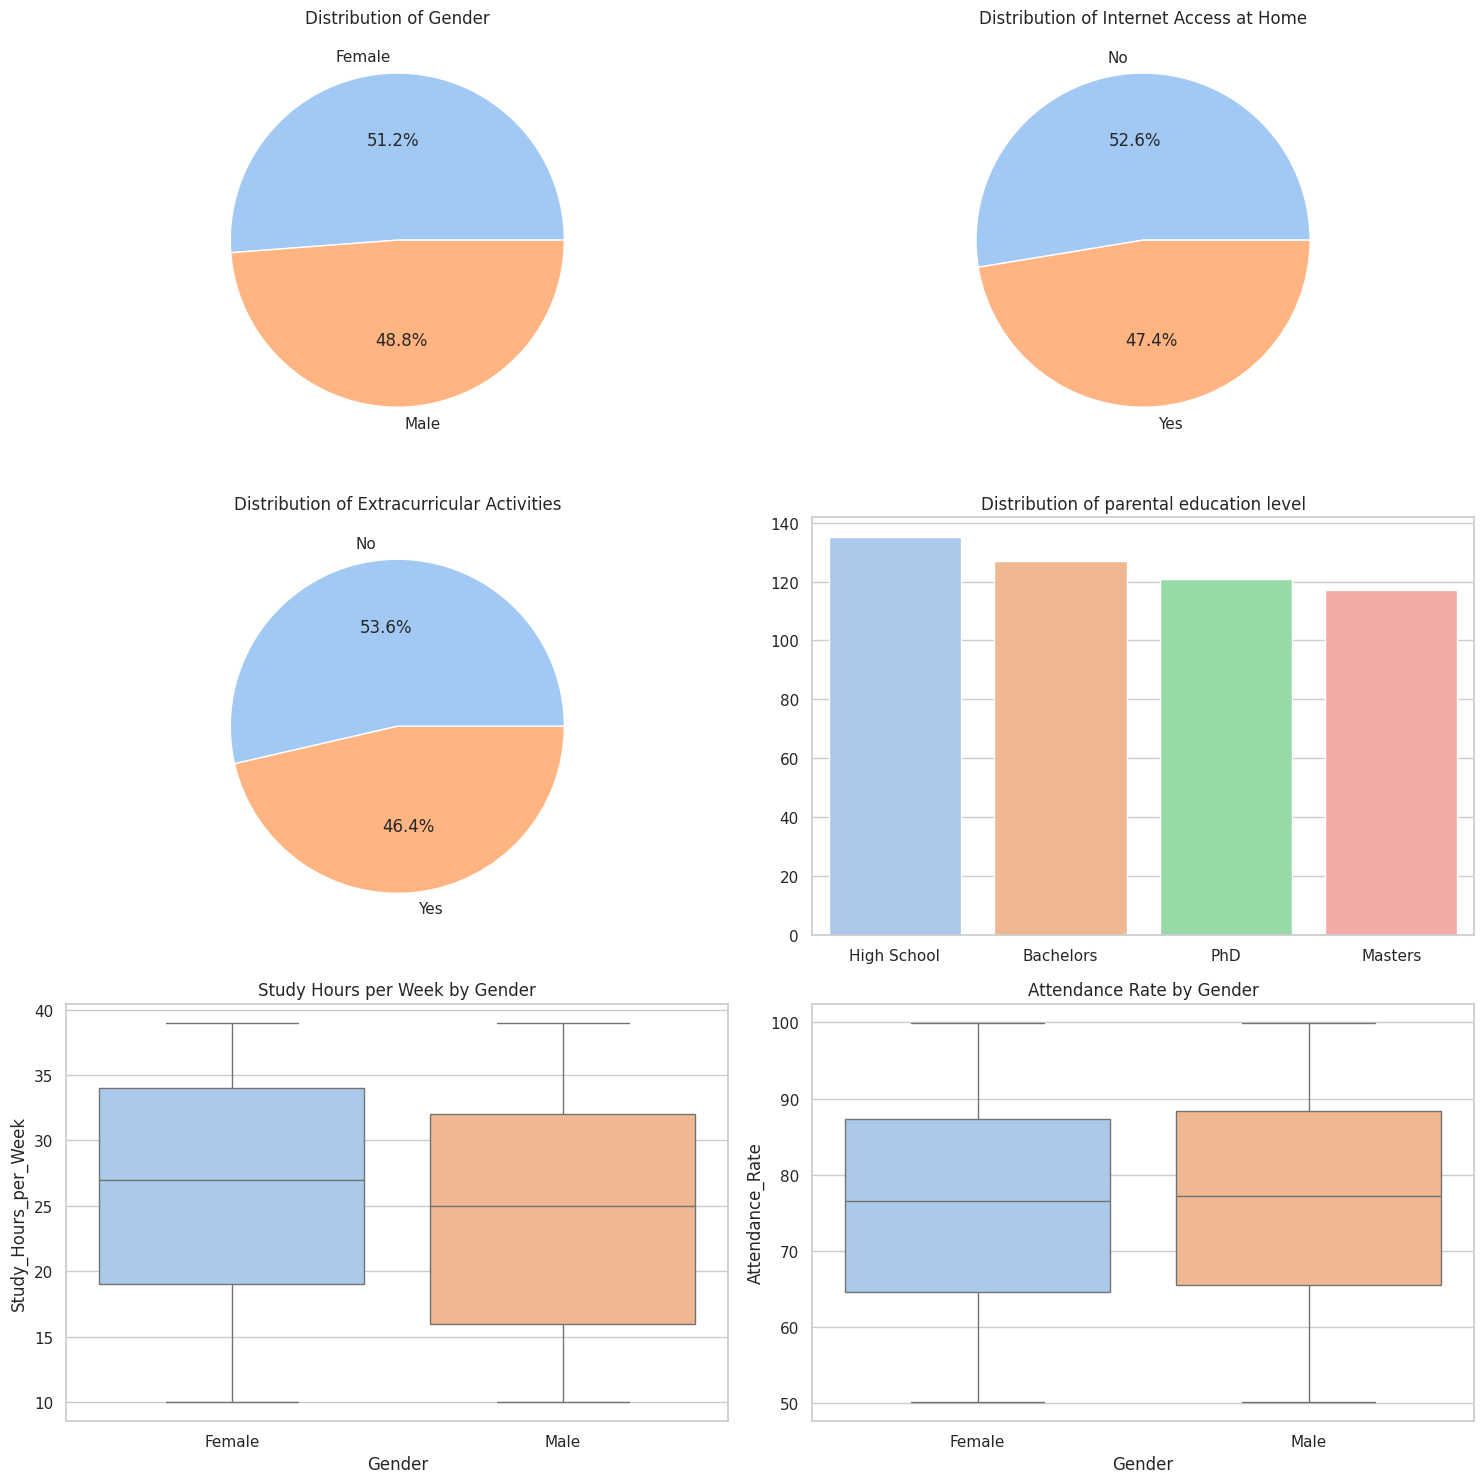

In [172]:
sns.set(style="whitegrid")

fig, axes = plt.subplots(3, 2, figsize=(15, 15))

# Gender
genders = data['Gender'].value_counts().to_dict()
axes[0, 0].pie(genders.values(), labels=genders.keys(), autopct='%1.1f%%', colors=sns.color_palette('pastel'))
axes[0, 0].set_title('Distribution of Gender')

# Internet_Access_at_Home
itn_access = data['Internet_Access_at_Home'].value_counts().to_dict()
axes[0, 1].pie(itn_access.values(), labels=itn_access.keys(), autopct='%1.1f%%', colors=sns.color_palette('pastel'))
axes[0, 1].set_title('Distribution of Internet Access at Home')

# Extracurricular_Activities
extr_act = data['Extracurricular_Activities'].value_counts().to_dict()
axes[1, 0].pie(extr_act.values(), labels=extr_act.keys(), autopct='%1.1f%%', colors=sns.color_palette('pastel'))
axes[1, 0].set_title('Distribution of Extracurricular Activities')

# Parental_Education_Level
par_edu = data['Parental_Education_Level'].value_counts().to_dict()
sns.barplot(x=list(par_edu.keys()), y=list(par_edu.values()), ax=axes[1, 1], palette='pastel', hue=list(par_edu.keys()))
axes[1, 1].set_title('Distribution of parental education level')

# Study Hours per Week by Gender
sns.boxplot(x='Gender', y='Study_Hours_per_Week', data=data, palette='pastel', hue='Gender', ax=axes[2, 0])
axes[2, 0].set_title('Study Hours per Week by Gender')

# Attendance_Rate by Gender
sns.boxplot(x='Gender', y='Attendance_Rate', data=data, palette='pastel', hue='Gender', ax=axes[2, 1])
axes[2, 1].set_title('Attendance Rate by Gender')

plt.tight_layout()
plt.show()


In [151]:
# xác định xem bao nhiêu điểm thì là Pass:
pass_min_score = data[data['Pass_Fail'] == 'Pass']['Final_Exam_Score'].min()
print("Điểm thấp nhất để pass là:", pass_min_score)

fail_max_score = data[data['Pass_Fail'] == 'Fail']['Final_Exam_Score'].max()
print("Điểm cao nhất trong nhóm Fail là:", fail_max_score)

Điểm thấp nhất để pass là: 60
Điểm cao nhất trong nhóm Fail là: 59


$\Rightarrow$ Ngưỡng điểm để pass là 60

In [74]:
# độ tương quan giữa các cột số
data[numeric_cols].corr()

,Study_Hours_per_Week,Attendance_Rate,Past_Exam_Scores,Final_Exam_Score
Study_Hours_per_Week,1.000000,-0.039701,-0.013381,0.374708
Attendance_Rate,-0.039701,1.000000,-0.022741,0.435714
Past_Exam_Scores,-0.013381,-0.022741,1.000000,0.474257
Final_Exam_Score,0.374708,0.435714,0.474257,1.000000


In [75]:
data[numeric_cols].corr()["Final_Exam_Score"]

,Final_Exam_Score
Study_Hours_per_Week,0.374708
Attendance_Rate,0.435714
Past_Exam_Scores,0.474257
Final_Exam_Score,1.000000


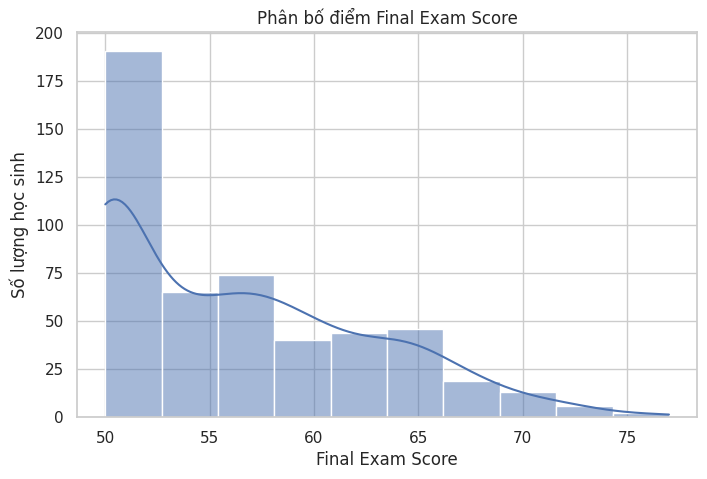

In [105]:
plt.figure(figsize=(8, 5))
sns.histplot(data['Final_Exam_Score'], kde=True)

plt.title('Phân bố điểm Final Exam Score')
plt.xlabel('Final Exam Score')
plt.ylabel('Số lượng học sinh')
plt.show()

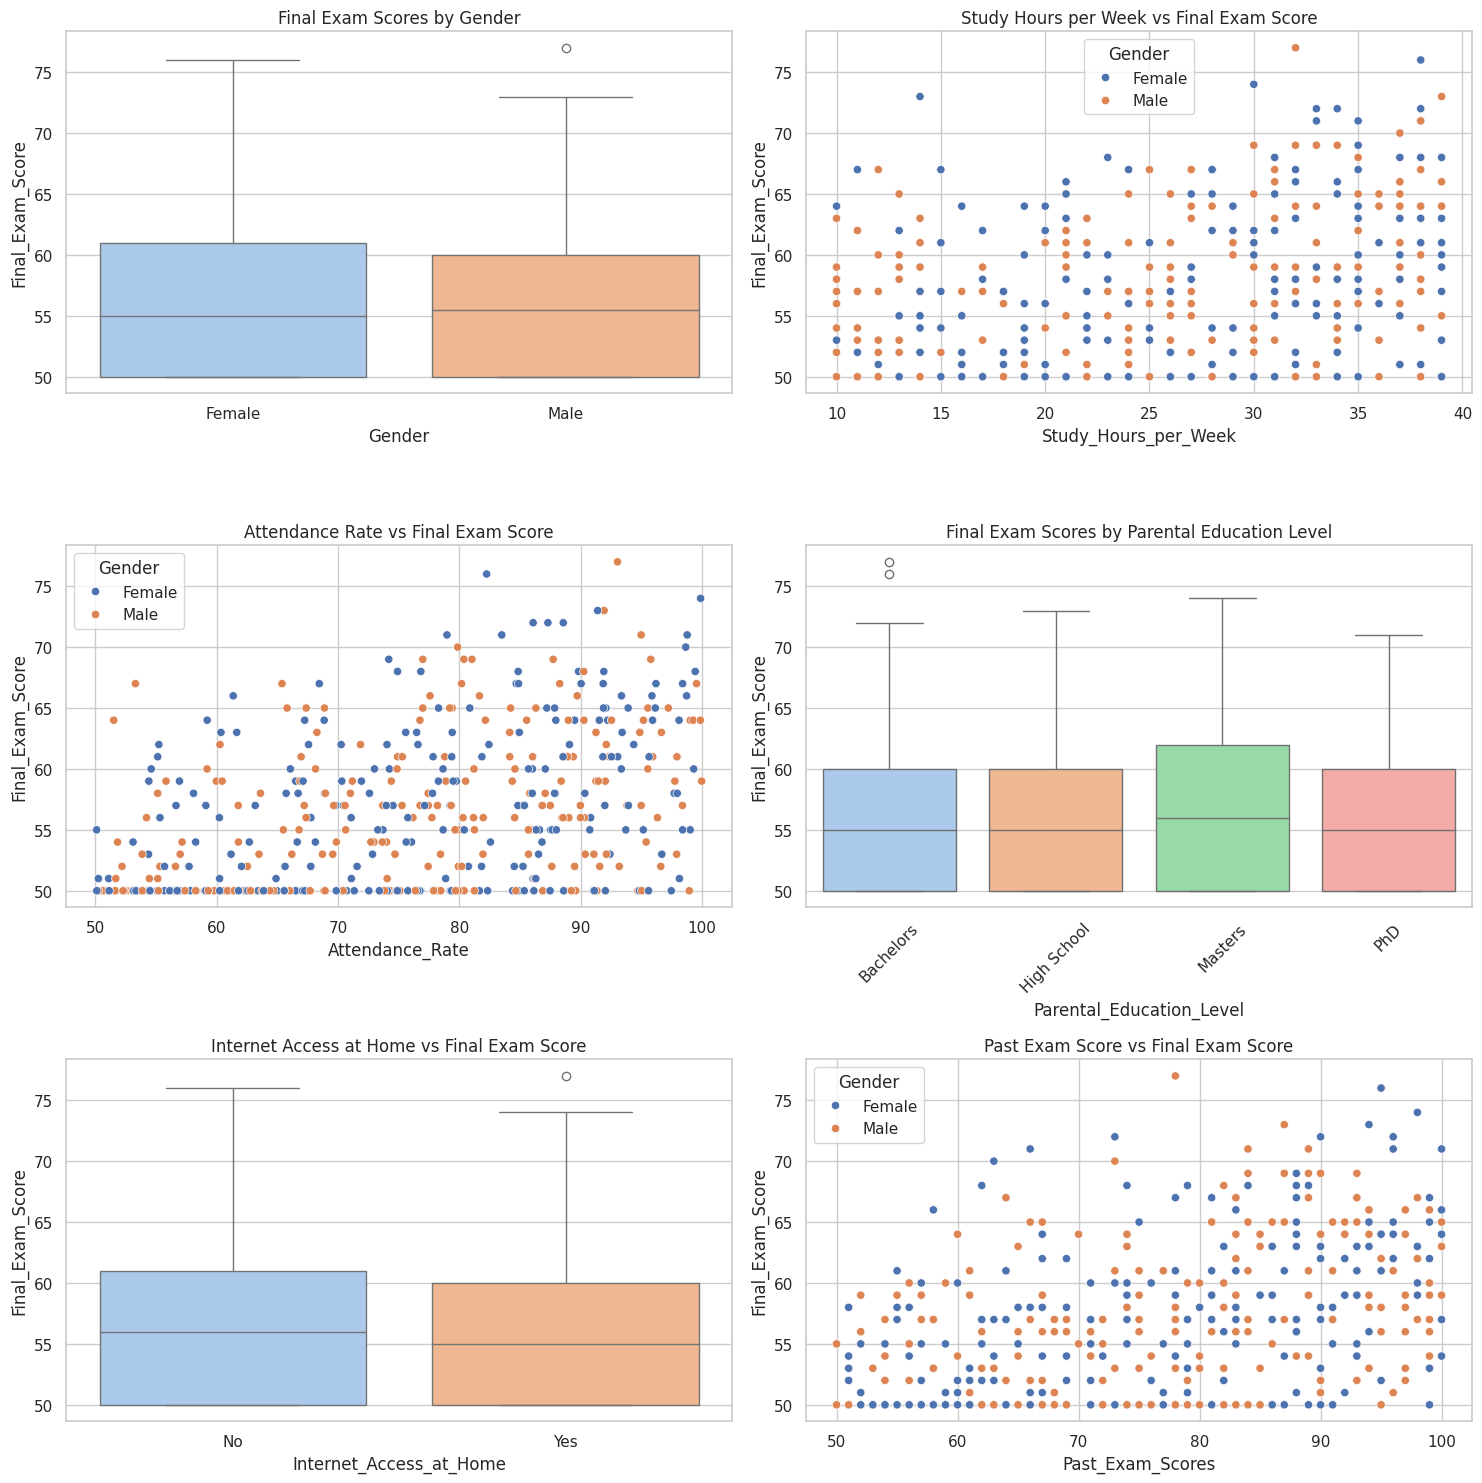

In [166]:
sns.set(style="whitegrid")

fig, axes = plt.subplots(3, 2, figsize=(15, 15))

# Final Exam Scores by Gender
sns.boxplot(x='Gender', y='Final_Exam_Score', data=data, ax=axes[0, 0], palette='pastel', hue='Gender')
axes[0, 0].set_title('Final Exam Scores by Gender')

# Study Hours per Week vs Final Exam Score
sns.scatterplot(x='Study_Hours_per_Week', y='Final_Exam_Score', hue='Gender', data=data, ax=axes[0, 1])
axes[0, 1].set_title('Study Hours per Week vs Final Exam Score')

# Attendance Rate vs Final Exam Score
sns.scatterplot(x='Attendance_Rate', y='Final_Exam_Score', hue='Gender', data=data, ax=axes[1, 0])
axes[1, 0].set_title('Attendance Rate vs Final Exam Score')

# Final Exam Scores by Parental Education Level
sns.boxplot(x='Parental_Education_Level', y='Final_Exam_Score', data=data, ax=axes[1, 1], palette='pastel', hue='Parental_Education_Level')
axes[1, 1].set_title('Final Exam Scores by Parental Education Level')
axes[1, 1].tick_params(axis='x', rotation=45)

# Internet Access at Home vs Final Exam Score
sns.boxplot(x='Internet_Access_at_Home', y='Final_Exam_Score', data=data, ax=axes[2, 0], palette='pastel', hue='Internet_Access_at_Home')
axes[2, 0].set_title('Internet Access at Home vs Final Exam Score')

# Past Exam Score vs Final Exam Score
sns.scatterplot(x='Past_Exam_Scores', y='Final_Exam_Score', hue='Gender', data=data, ax=axes[2, 1])
axes[2, 1].set_title('Past Exam Score vs Final Exam Score')

plt.tight_layout()
plt.show()


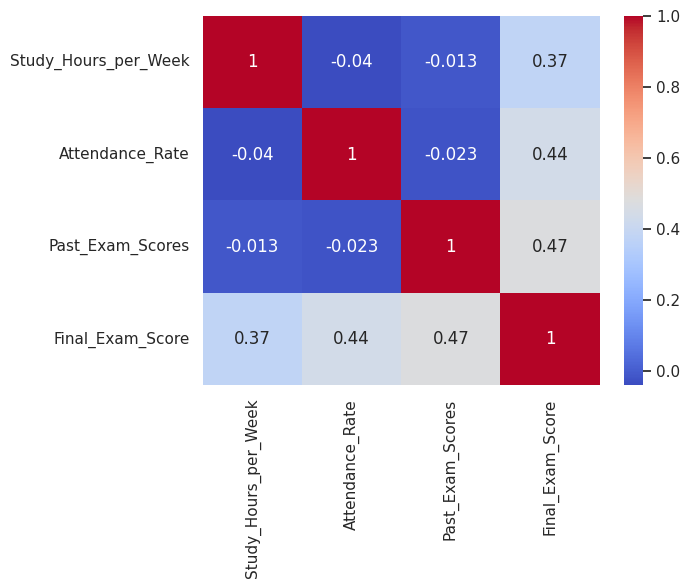

In [184]:
sns.heatmap(data[numeric_cols].corr(),annot=True, cmap='coolwarm')
plt.show()

## 2. Phân loại học sinh
- Phân loại học sinh trượt / không trượt
- Sử dụng các mô hình

## 3. Dự đoán điểm số
- Dự đoán điểm tương lai dựa trên dữ liệu quá khứ
- Mô hình hồi quy

## 4. Đánh giá mô hình
- So sánh độ hiệu quả các mô hình